In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
from sklearn import metrics
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [2]:
db1 = pd.read_csv('signal-data.csv')
db1 = db1.drop(['Time'], axis = 1)
val = pd.read_excel('Future_predictions.xlsx')
val = val.drop(['Time'], axis= 1)
print(db1.shape)
val['Pass/Fail'] = db1['Pass/Fail']
print(val.shape)
db = pd.concat([db1, val], ignore_index = True)

(1567, 591)
(18, 591)


In [3]:
print(db.isnull().sum()) #missing values

0        24
1        25
2        32
3        32
4        32
       ... 
585    1567
586    1568
587    1568
588    1568
589    1568
Length: 1181, dtype: int64


In [4]:
db.describe().T #5 point summary

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.650000,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.822500,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.055500,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.223500,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
585,18.0,8.454061,22.725950,1.5352,2.133925,3.0375,3.387075,99.3032
586,17.0,0.024353,0.011960,0.0096,0.018400,0.0202,0.034200,0.0584
587,17.0,0.019053,0.009203,0.0098,0.014900,0.0151,0.020100,0.0484
588,17.0,0.005965,0.002755,0.0034,0.004400,0.0052,0.007100,0.0148


In [5]:
#dropping the columns with zero singal
cols = db.select_dtypes([np.number]).columns
std = db[cols].std()
cols_to_drop = std[std==0].index
db.drop(cols_to_drop, axis=1,inplace=True)
#types
db.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
585    float64
586    float64
587    float64
588    float64
589    float64
Length: 937, dtype: object

In [6]:
db.shape #after dropping columns with zero signal.

(1585, 937)

In [7]:
#label encoding the target attribute class
db['Pass/Fail']=db['Pass/Fail'].replace([-1,1],[0,1])

In [8]:
# missing values among rows
n_rows = db.isnull().any(axis = 1).sum()
print(n_rows)

1585


#### All the rows in the dataframe have atleast one missing value.

In [9]:
# dataframe contains NaN values throughout
# So, filling them with 0 
db.fillna(0, inplace=True)

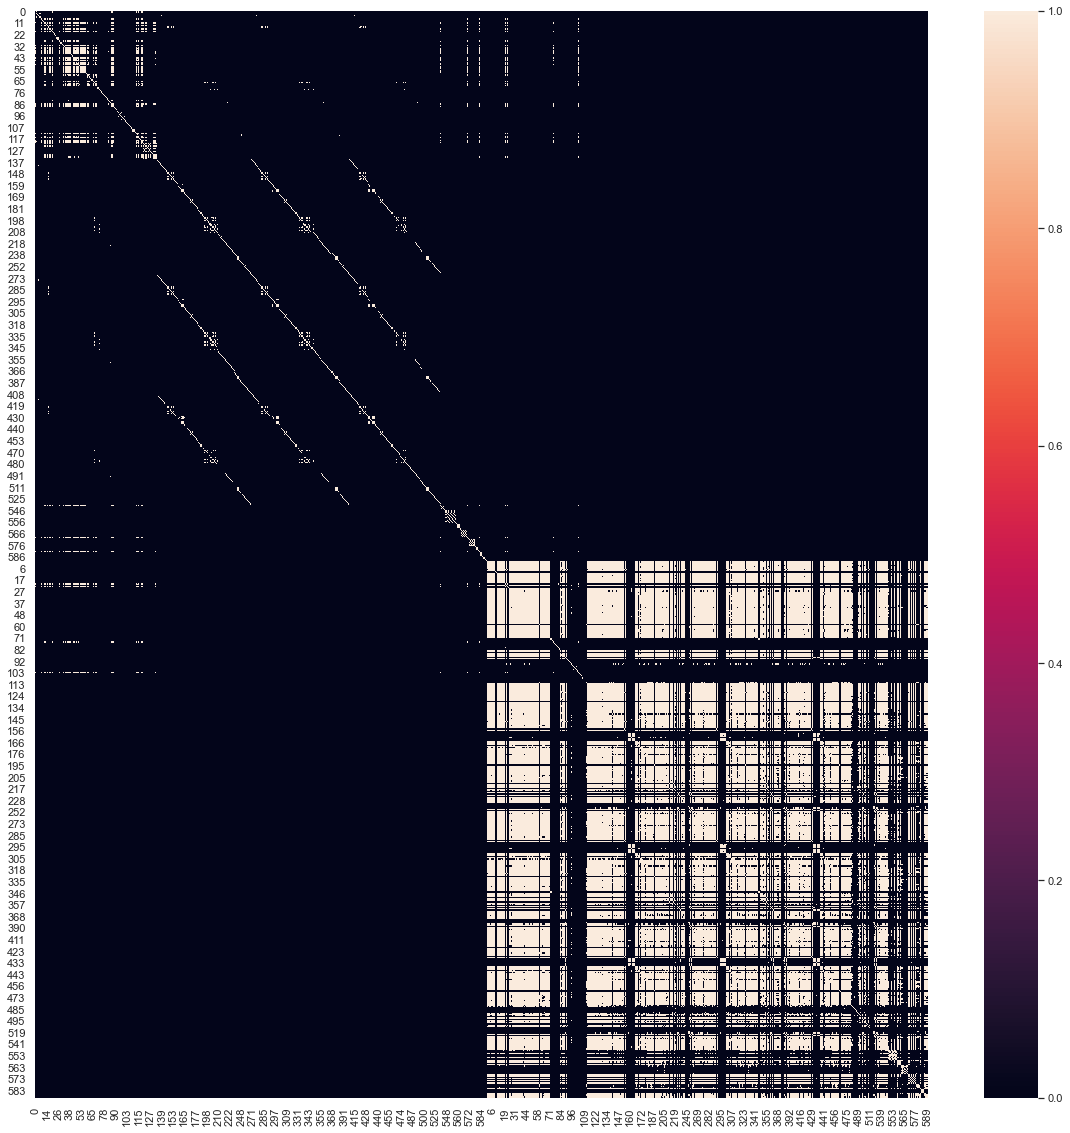

In [10]:
#copy of the original dataframe.
db_copy = db.copy()
# dropping target 
db_copy.drop(['Pass/Fail'], axis = 1,inplace = True)
# correlation
plt.figure(figsize=(20,20))
cm = db.corr()
sns.heatmap(abs(cm>0.8));


In [11]:
#corr_matrix
corr_matrix = db_copy.corr().abs()
# upper Triangle of corr_matrix can be obtained by the function triu()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# features with correlation Greater than 0.8 are to be dropped
drop_features = [column for column in upper.columns if any(upper[column] > 0.8)]
# Dropping them
db_copy.drop(drop_features, axis = 1,inplace = True)

In [12]:
db_copy.shape #After dropping featues with correlation > 0.8

(1585, 241)

In [13]:
db['Pass/Fail'].value_counts(normalize = True)

0    0.931861
1    0.068139
Name: Pass/Fail, dtype: float64

distribution of target shows that our dataframe is highly imbalanced.

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: P

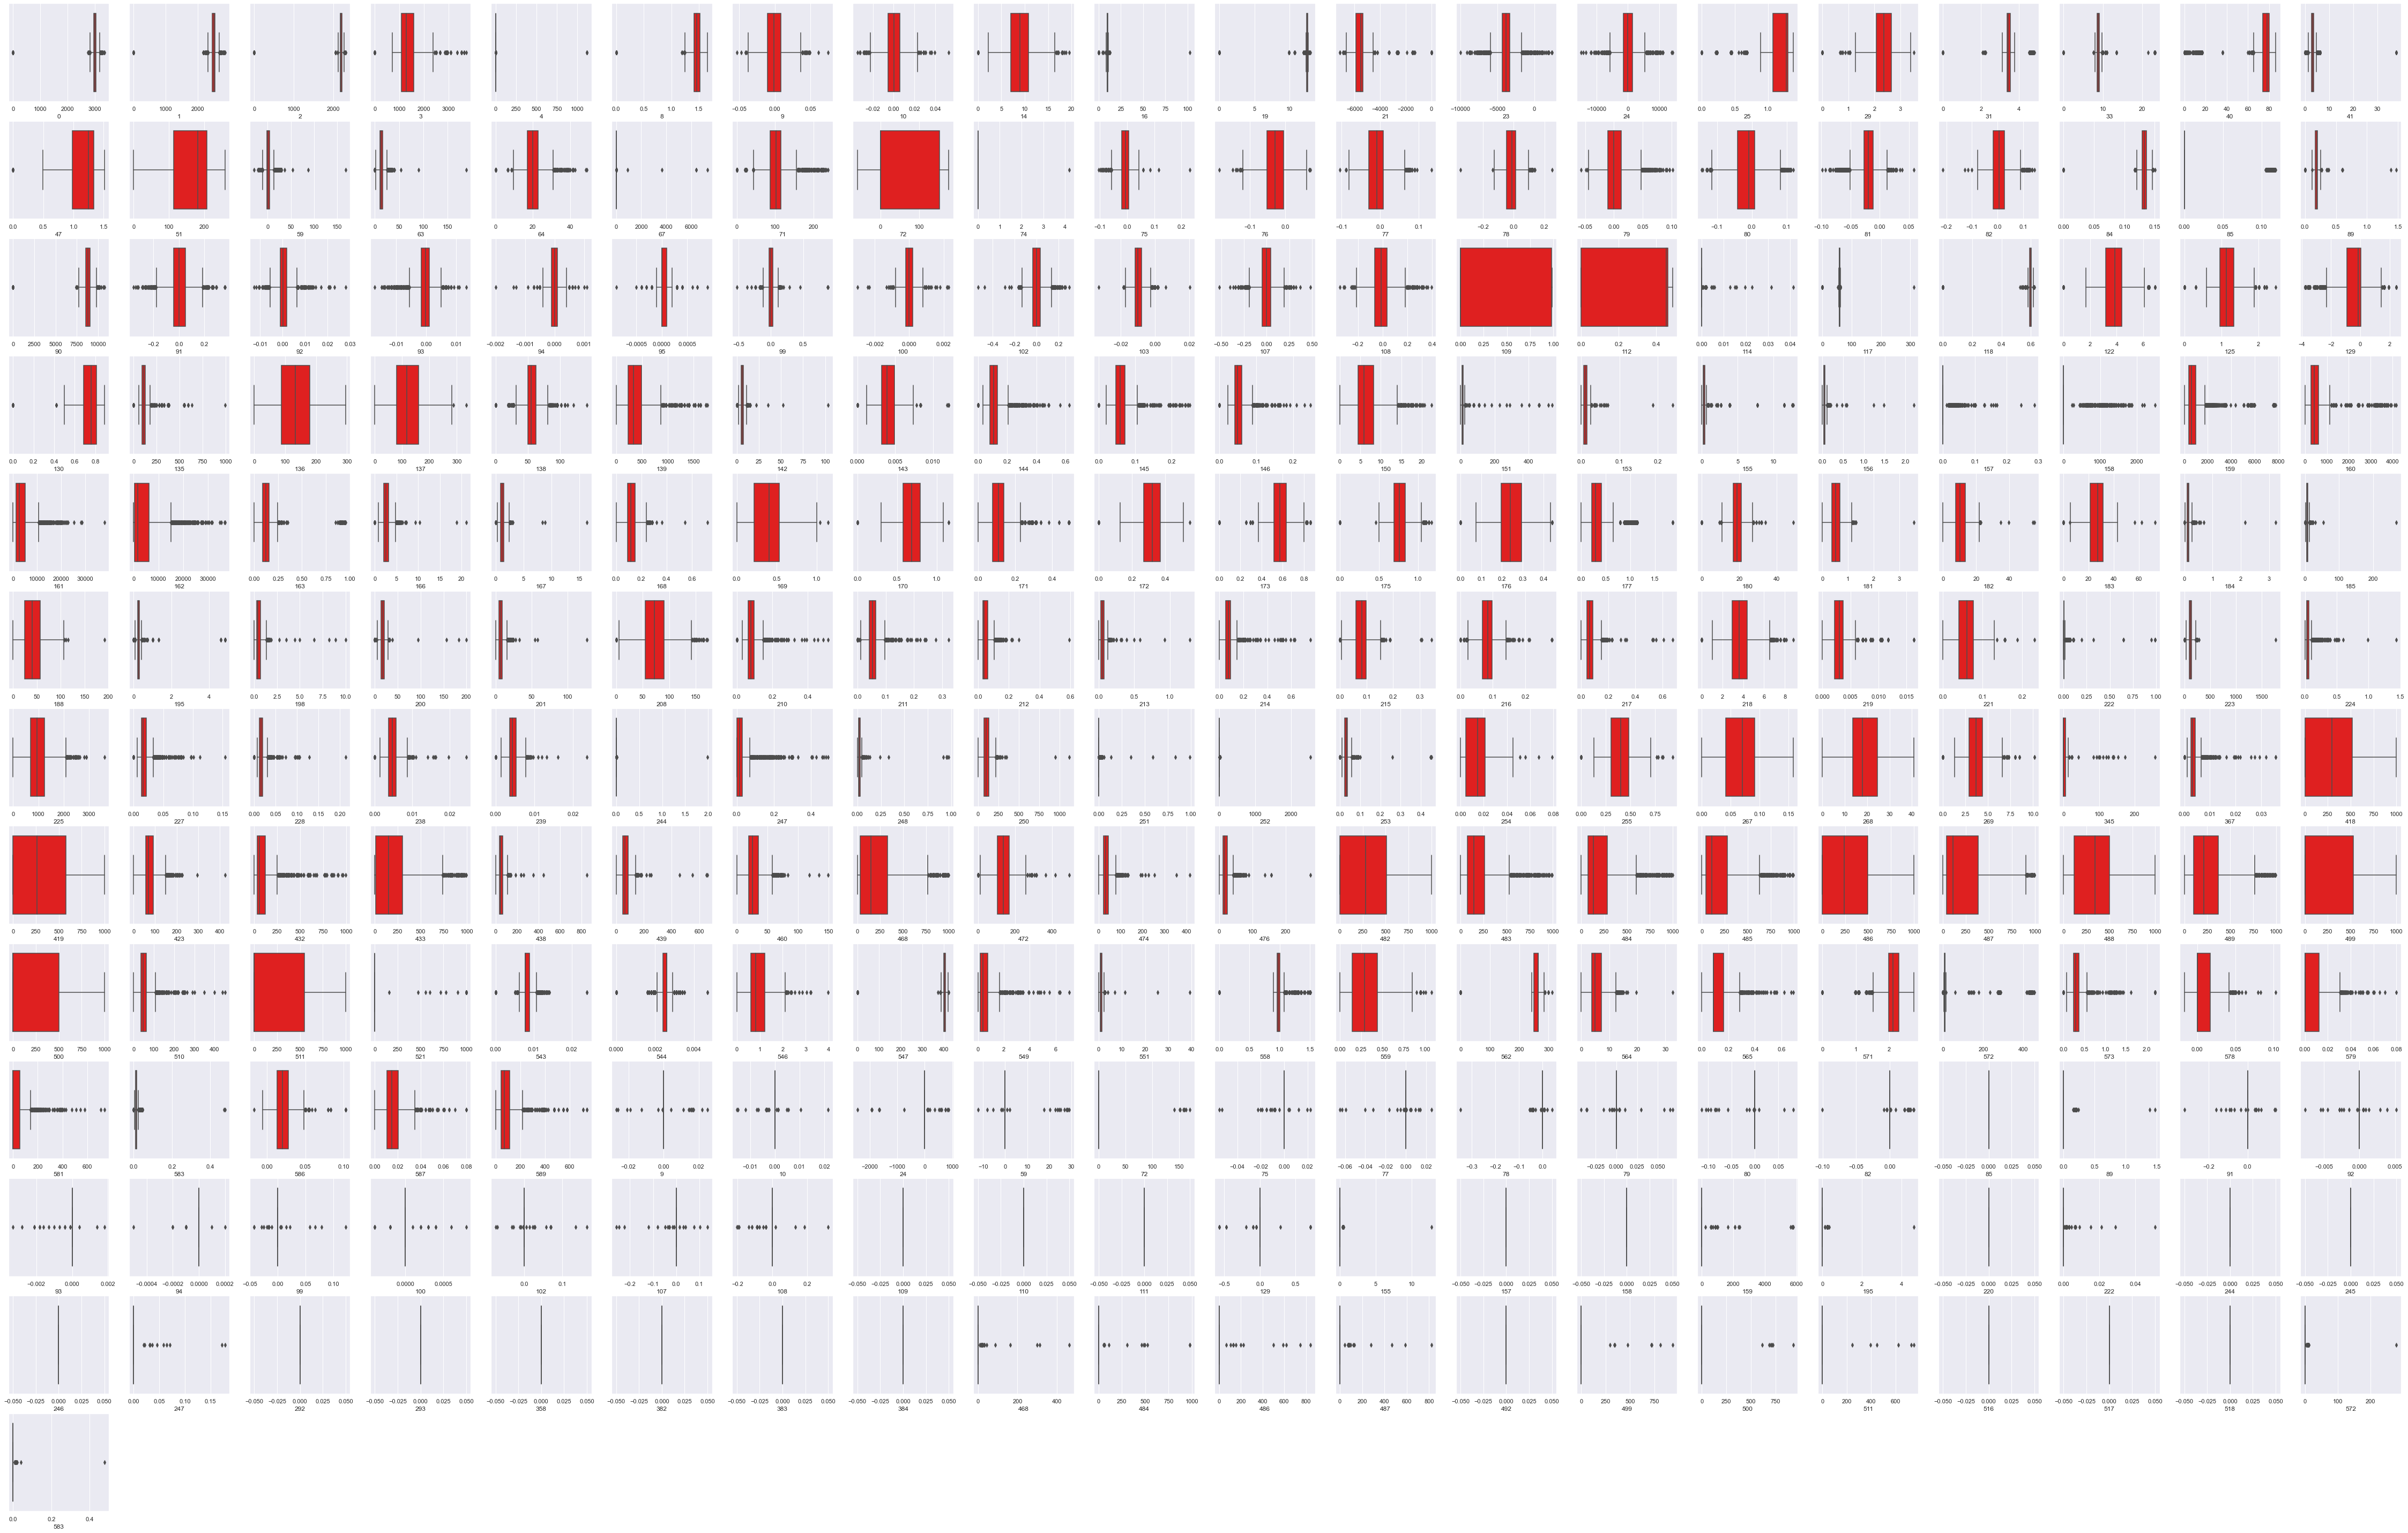

In [14]:
# Outlier check
plt.figure(figsize=(80, 80))
col = 1
for i in db_copy.columns:
    plt.subplot(20,20, col)
    sns.boxplot(db_copy[i],color='red')
    col += 1

In [15]:
# replacing them with median
# Identifying outliers and replacing them using 1.5*iqr rule
# where IQR is inter Quartile Range
for i in db_copy.columns:
    q1 = db_copy[i].quantile(0.25)
    q3 = db_copy[i].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    db_copy.loc[(db_copy[i] < low) | (db_copy[i] > high), i] = db_copy[i].median()
    
db_copy.shape    

(1585, 241)

Now the outliers are treated.

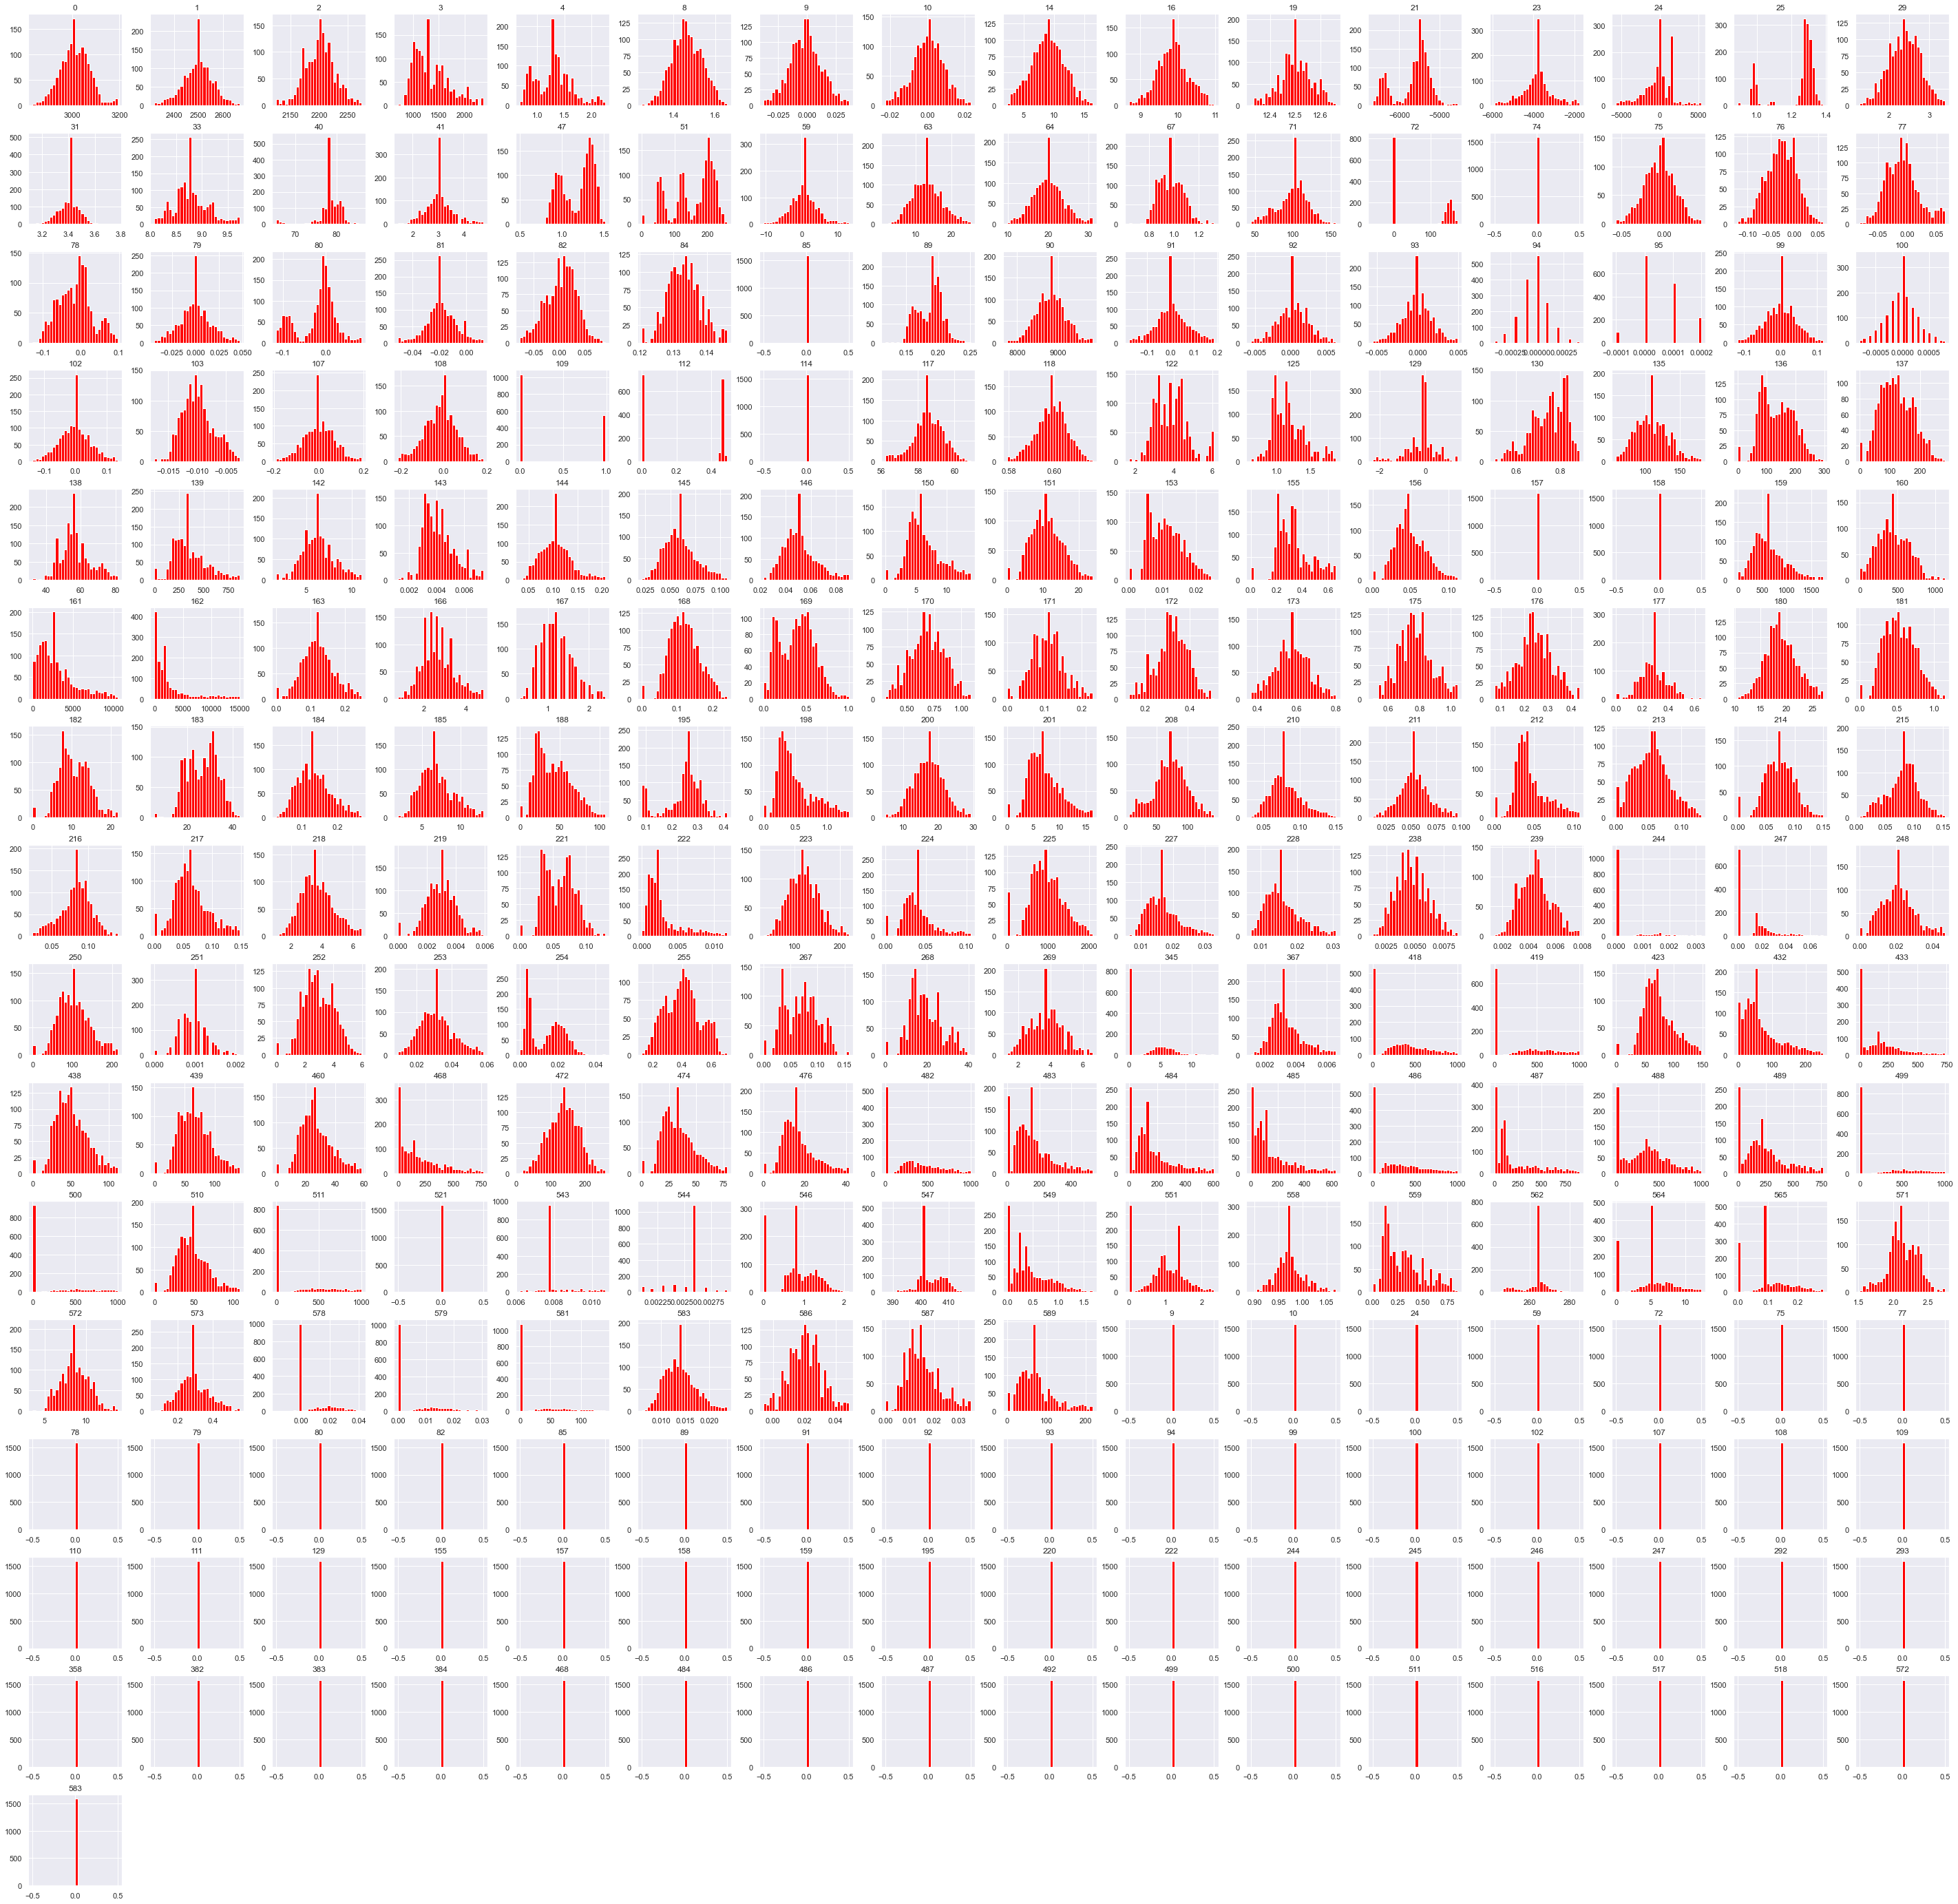

In [16]:
# Histogram
db_copy.hist(bins= 30,figsize=(50,50), color='red')
plt.show()

In [17]:
# Z-score scaling 
dbs = db_copy.apply(zscore)
dbs.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1585.0,-1.537476e-15,1.000316,-2.909589,-0.663241,-0.001495,0.671245,2.970461
1,1585.0,-1.726217e-15,1.000316,-2.959243,-0.611729,0.017128,0.621665,2.873559
2,1585.0,3.350470e-15,1.000316,-2.926710,-0.683232,-0.022054,0.640839,2.812373
3,1585.0,-1.928006e-16,1.000316,-1.872454,-0.777945,-0.210740,0.596780,2.977695
4,1585.0,6.416178e-16,1.000316,-1.854899,-0.832136,0.016745,0.580955,2.864662
...,...,...,...,...,...,...,...,...
516,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# combining data of Zscore scaled db and target attribute 
y = db['Pass/Fail']
db_comb = pd.concat([dbs,y], axis = 1)

#dropping NaN values still present in the dbs from the combined dataframe
db_comb.dropna(axis = 1,inplace = True)
db_comb.shape #after dropping NaN variables

(1585, 180)

In [19]:
# Now splitting the dataset into train and validation set
X = db_comb.iloc[0:1567,:]
val_new = db_comb.iloc[1567:1585,:181]
val_new = val_new.drop(['Pass/Fail'], axis = 1)

In [20]:
# a copy of the train data 
cpy_t = X.copy()
X = cpy_t.drop(['Pass/Fail'], axis = 1)
y = cpy_t['Pass/Fail']
print(val_new.shape)
print(X.shape)

(18, 179)
(1567, 179)


-> Reduced validation set contains 18 rows and 179 columns.

-> Reduced training set contains 1567 rows and 179 columns

In [21]:
# Splitting the data into train, test. ratio of 70.30
X_train, X_test, Y_train, Y_test =train_test_split(X,y, test_size=.30,random_state=105,stratify=y)

In [22]:
print("Training Fail    : {0} ".format(len(Y_train[Y_train[:] == 1])))
print("Training Pass  : {0} ".format(len(Y_train[Y_train[:] == 0])))
print("")
print("Test Fail        : {0} ".format(len(Y_test[Y_test[:] == 1])))
print("Test Pass       : {0} ".format(len(Y_test[Y_test[:] == 0])))

Training Fail    : 73 
Training Pass  : 1023 

Test Fail        : 31 
Test Pass       : 440 


### No Sampling

In [23]:
# Appending different classification algorithms and choosing the best one for tuning with the help of f1 score
#  no sampling dataset
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

LR: 15.127631%
KNN: 0.000000%
GNB: 19.246515%
SVM: 14.433575%
DT: 10.949939%
RF: 0.000000%
AB: 10.666667%
GBT: 6.262626%


Best one being GaussianNB

### RandomUnder Sampling

In [24]:
under= RandomUnderSampler(sampling_strategy=0.5)
X_under, Y_under= under.fit_sample(X_train, Y_train)

In [25]:
# under sampling dataset
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_under, Y_under, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

LR: 46.114469%
KNN: 39.477855%
GNB: 50.273810%
SVM: 47.574876%
DT: 36.921326%
RF: 12.944444%
AB: 47.588384%
GBT: 30.915751%


Best one being Logistic Regression.

### Random oversampling 

In [26]:
over= RandomOverSampler(sampling_strategy=0.5)
X_over, Y_over= over.fit_sample(X_train, Y_train)

In [27]:
# oversampling dataset
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_over, Y_over, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

LR: 86.565601%
KNN: 85.841357%
GNB: 68.406196%
SVM: 88.760847%
DT: 92.606373%
RF: 100.000000%
AB: 90.811373%
GBT: 99.518279%


best one being Random Forest

#### GuassianNB on no sampling dataset


In [28]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_score = nb.score(X_train, Y_train)
print('Accuracy on train data', nb_score)
y_prednb = nb.predict(X_test)
nb_score1 = accuracy_score(Y_test, y_prednb)
print('Accuracy score on test data', nb_score1)

Accuracy on train data 0.8768248175182481
Accuracy score on test data 0.851380042462845


In [29]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_prednb, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.19      0.39      0.26        31
           0       0.95      0.88      0.92       440

    accuracy                           0.85       471
   macro avg       0.57      0.64      0.59       471
weighted avg       0.90      0.85      0.87       471



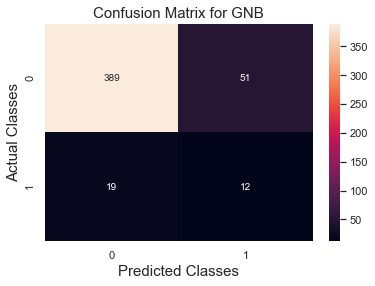

In [30]:
# Confusion Matrix
cm= confusion_matrix(Y_test, y_prednb)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted Classes', fontsize = 15)
plt.ylabel('Actual Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB', fontsize = 15);

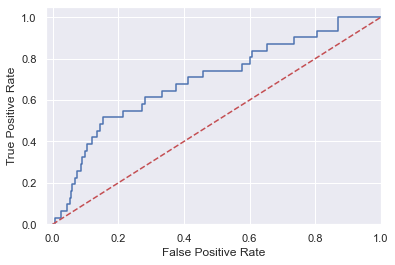

In [31]:
# plotting curves
probs = nb.predict_proba(X_test)
prednb = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, prednb)
roc_auc_nb = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='GaussianNB(AUC = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

      fpr       tpr  1-fpr        tf  threshold
42  0.375  0.645161  0.625  0.020161   0.005834


In [33]:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
# predict diabetes if the predicted probability is greater than 0.005834
y_pred_class = binarize([y_pred_prob], 0.005834)[0]

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.005834 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


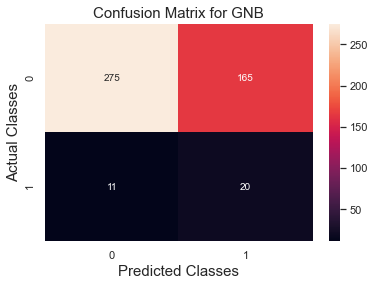

In [34]:
# confusion matrix 
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted Classes', fontsize = 15)
plt.ylabel('Actual Classes', fontsize = 15)
plt.title('Confusion Matrix for GNB', fontsize = 15);

In [35]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.11      0.65      0.19        31
           0       0.96      0.62      0.76       440

    accuracy                           0.63       471
   macro avg       0.53      0.64      0.47       471
weighted avg       0.91      0.63      0.72       471



In [36]:
precision_nb, recall_nb, f1_score_nb, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_nb)
print('Recall Score :', '%0.2f' % recall_nb)
print('F1-Score:', '%0.2f' % f1_score_nb)
nb_acc= accuracy_score(Y_test, y_prednb)
print('Accuracy Score :','%0.2f' % nb_acc)
print('AUC :','%0.2f' % roc_auc_nb)
print('Thresholdnb :','%0.2f' % 0.0058)
Thresholdnb=0.0058

Precision Score : 0.53
Recall Score : 0.64
F1-Score: 0.47
Accuracy Score : 0.85
AUC : 0.70
Thresholdnb : 0.01


### Logistic Regression on UnderSampled data 

In [37]:
lr = LogisticRegression()
lr.fit(X_under,Y_under)

lr_score = lr.score(X_under, Y_under)
print('Accuracy of train data', lr_score)
y_predlr = lr.predict(X_test)
lr_score1 = accuracy_score(Y_test, y_predlr)
print('Accuracy on test data', lr_score1)
print("Classification Report")
print(metrics.classification_report(Y_test, y_predlr, labels=[1, 0]))

Accuracy of train data 1.0
Accuracy on test data 0.7070063694267515
Classification Report
              precision    recall  f1-score   support

           1       0.12      0.55      0.20        31
           0       0.96      0.72      0.82       440

    accuracy                           0.71       471
   macro avg       0.54      0.63      0.51       471
weighted avg       0.90      0.71      0.78       471



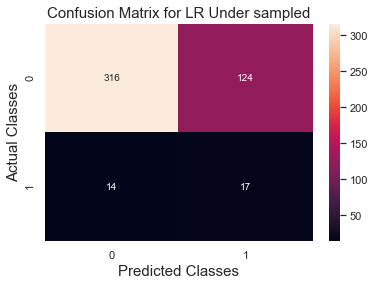

In [38]:
cm= confusion_matrix(Y_test, y_predlr)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LR Under sampled', fontsize = 15);

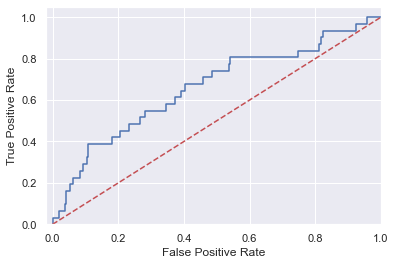

In [39]:
probs = lr.predict_proba(X_test)
predlr = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, predlr)
roc_auc_lr= metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LR(AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [40]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
35  0.390909  0.612903  0.609091  0.003812   0.134702


In [41]:
y_pred_prob = lr.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.134702
y_pred_class = binarize([y_pred_prob], 0.134702)[0]

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.169742 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


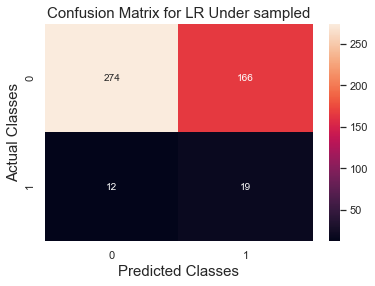

In [42]:
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for LR Under sampled', fontsize = 15);

In [107]:
precision_lr, recall_lr, f1_score_lr, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_lr)
print('Recall Score :', '%0.2f' % recall_lr)
print('F1-Score:', '%0.2f' % f1_score_lr)
lr_acc= accuracy_score(Y_test, y_predlr)
print('Accuracy Score :','%0.2f' % lr_acc)
print('AUC :','%0.2f' % roc_auc_lr)
print('Thresholdlr :','%0.2f' % 0.134702)
Thresholdlr=0.134702

Precision Score : 0.51
Recall Score : 0.53
F1-Score: 0.42
Accuracy Score : 0.71
AUC : 0.66
Thresholdlr : 0.13


### RandomForest on Random oversampled data

In [44]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = range(2,100,5)
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [45]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)
rf_random.fit(X_over, Y_over)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [46]:
rf_grid = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)
rf_grid.fit(X_over, Y_over)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [47]:
rfg_score=rf_grid.score(X_over,Y_over)
print('Accuracy Score of Training Data: ', rfg_score)
y_predrfg= rf_grid.predict(X_test)
rfg1_score = accuracy_score(Y_test, y_predrfg)
print('Accuracy Score of Test Data:', rfg1_score)

Accuracy Score of Training Data:  1.0
Accuracy Score of Test Data: 0.9341825902335457


In [48]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_predrfg, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


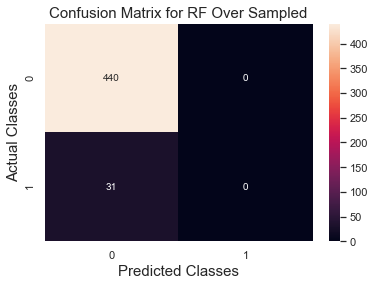

In [49]:
cm= confusion_matrix(Y_test, y_predrfg)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF Over Sampled', fontsize = 15);

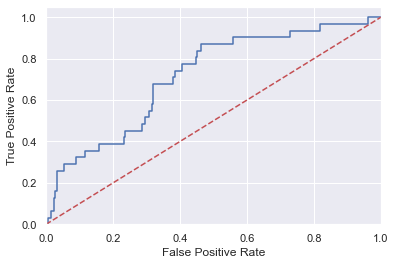

In [50]:
probs = rf_grid.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_rf = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RF over sampled (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [51]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])


         fpr       tpr     1-fpr        tf  threshold
37  0.320455  0.677419  0.679545 -0.002126   0.161671


In [52]:
y_pred_prob = rf_grid.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.161671
y_pred_class = binarize([y_pred_prob], 0.161671)[0]

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.155731 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [53]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.11      0.68      0.20        31
           0       0.97      0.63      0.76       440

    accuracy                           0.63       471
   macro avg       0.54      0.65      0.48       471
weighted avg       0.91      0.63      0.73       471



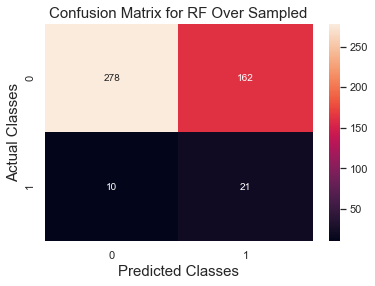

In [54]:
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF Over Sampled', fontsize = 15);

In [108]:
precision_rf, recall_rf, f1_score_rf, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_rf)
print('Recall Score :', '%0.2f' % recall_rf)
print('F1-Score:', '%0.2f' % f1_score_rf)
rf_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % rf_acc)
print('AUC :','%0.2f' % roc_auc_rf)
print('Thresholdrf :','%0.2f' % 0.161671)
Thresholdrf=0.161671

Precision Score : 0.51
Recall Score : 0.53
F1-Score: 0.42
Accuracy Score : 0.56
AUC : 0.72
Thresholdrf : 0.16


In [109]:
modellists = []
modellists.append(['Gaussian NB Normal Data', nb_acc * 100, recall_nb * 100, precision_nb * 100,roc_auc_nb*100,f1_score_nb*100,Thresholdnb])
modellists.append(['Logistic Regression under samples data', lr_acc* 100, recall_lr * 100, precision_lr* 100,roc_auc_lr*100,f1_score_lr*100,Thresholdlr])
modellists.append(['Random Forest Over sampled Data', rf_acc * 100, recall_rf * 100, precision_rf * 100,roc_auc_rf*100,f1_score_rf*100,Thresholdrf])
model_df = pd.DataFrame(modellists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','AUC','F1 Score','Threshold'])
model_df

,Model,Accuracy Scores on Test,Recall Score,Precision Score,AUC,F1 Score,Threshold
0,Gaussian NB Normal Data,85.138004,63.508065,53.482328,69.743402,47.138047,0.005800
1,Logistic Regression under samples data,70.700637,52.716276,50.680216,65.989736,41.885100,0.134702
2,Random Forest Over sampled Data,56.475584,52.716276,50.680216,71.502933,41.885100,0.161671


#### Dimensionality Reduction and to rebuild the models.

In [57]:
db.dropna(axis = 1,inplace = True)
sg = db.iloc[0:1567,:]
y = sg['Pass/Fail']
sg = sg.drop(['Pass/Fail'], axis = 1)
sg.shape

(1567, 936)

In [58]:
val=db.iloc[1567:1586,:]
val = val.drop(['Pass/Fail'], axis = 1)
val.shape

(18, 936)

In [59]:
# Scaling with z score
db_scaled = db.apply(zscore)
#dropping nan
db_scaled.dropna(axis = 1,inplace = True)
db_scaled = db_scaled.drop(['Pass/Fail'],axis = 1)

In [60]:
X = db_scaled.iloc[0:1567,:]
val = db_scaled.iloc[1567:,:]
X.shape,val.shape

((1567, 916), (18, 916))

In [61]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca = pca.fit(X)
pca

PCA(n_components=0.95)

In [62]:
X_pca = pca.transform(X)
val_pca = pca.transform(val)
X_pca.shape, val_pca.shape

((1567, 144), (18, 144))

In [63]:
pca.explained_variance_

array([25.64642994, 17.33151495, 13.35304915, 11.96696133,  9.37719342,
        8.99009958,  8.40677756,  7.6922684 ,  6.66810574,  6.46092526,
        6.31580717,  6.19281863,  5.95598685,  5.79696884,  5.35410224,
        5.26099542,  5.06604069,  4.90396991,  4.75329922,  4.63218349,
        4.43401845,  4.33359773,  4.22284361,  4.18151826,  4.09005766,
        4.00554123,  3.97888855,  3.90404305,  3.75973854,  3.62443086,
        3.50466576,  3.39872249,  3.36609508,  3.29803371,  3.24592986,
        3.20430097,  3.17421655,  3.14977299,  3.04772965,  3.03899757,
        2.9805035 ,  2.91357676,  2.89259487,  2.86795675,  2.78868714,
        2.76716515,  2.68500978,  2.60083904,  2.5727415 ,  2.55188323,
        2.51047549,  2.47775958,  2.43083279,  2.4154267 ,  2.37239998,
        2.33007285,  2.29148194,  2.20407151,  2.15989381,  2.15038246,
        2.11892194,  2.05656184,  2.02144487,  1.99073124,  1.96961305,
        1.9489231 ,  1.9432757 ,  1.88875561,  1.82180622,  1.79

In [64]:
db_pca = pd.DataFrame(X_pca)
df = pd.concat([db_pca, y], axis = 1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Pass/Fail
0,-1.283065,4.351272,4.120308,-0.549811,-1.760026,1.007882,1.177122,1.572132,2.034015,1.362149,...,0.809727,0.170418,1.006332,-0.909711,0.615176,0.152751,-1.284096,-0.418824,-1.344065,0
1,-1.860440,2.629551,3.270138,-0.486132,-2.185497,0.325068,-0.229419,2.328523,2.114517,0.176404,...,0.344981,-0.525531,0.278998,-0.398244,0.278413,-0.628814,-0.027535,1.152883,0.232930,0
2,0.295222,1.859737,0.076620,-0.235589,0.184562,-0.491966,-2.064320,2.220131,2.630336,0.945849,...,-0.244392,-1.070951,0.534904,-0.488806,1.449064,-1.387350,-0.558858,0.146147,-0.633033,1
3,0.407512,1.915329,-2.530951,3.595905,-1.725894,-10.912146,-8.174610,33.846805,-11.802413,-7.837307,...,0.450658,-0.612588,-0.412328,0.279224,0.636476,-0.422995,0.683557,-0.059384,-0.886568,0
4,0.072680,4.263879,2.661011,0.397809,-0.413636,-0.038142,-0.047164,3.398999,-5.841470,-0.774409,...,0.220959,0.321481,0.110647,-1.430587,-0.506574,-0.134018,0.408281,0.723507,-0.301989,0


In [65]:
X = df.drop(['Pass/Fail'], axis = 1)
y = df['Pass/Fail']

In [66]:
# Splitting data into train and test in the ratio 70:30
X_train, X_test, Y_train, Y_test =train_test_split(X,y, test_size=.30,random_state=105,stratify=y)

In [67]:
print("Training Fail    : {0} ".format(len(Y_train[Y_train[:] == 1])))
print("Training Pass  : {0} ".format(len(Y_train[Y_train[:] == 0])))
print("")
print("Test Fail        : {0} ".format(len(Y_test[Y_test[:] == 1])))
print("Test Pass       : {0} ".format(len(Y_test[Y_test[:] == 0])))

Training Fail    : 73 
Training Pass  : 1023 

Test Fail        : 31 
Test Pass       : 440 


#### No sampling 

In [68]:
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

LR: 16.991007%
KNN: 0.000000%
GNB: 17.471046%
SVM: 18.859588%
DT: 13.816993%
RF: 0.000000%
AB: 4.166667%
GBT: 9.484848%


Best one being SVM

#### Random under Sampliing 

In [69]:
under= RandomUnderSampler(sampling_strategy=0.5)
X_under, Y_under= under.fit_sample(X_train, Y_train)


models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_under, Y_under, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

LR: 40.134759%
KNN: 30.416306%
GNB: 42.803243%
SVM: 41.149479%
DT: 33.324930%
RF: 8.444444%
AB: 32.160617%
GBT: 27.432567%


best one being SVM

#### Random Over Sampling 

In [70]:
over= RandomOverSampler(sampling_strategy=0.5)
X_over, Y_over= over.fit_sample(X_train, Y_train)

In [71]:
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("GNB", GaussianNB()))
models.append(("SVM", SVC(kernel='linear')))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))

result = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=55,shuffle=True)
    cv_result = cross_val_score(model, X_over, Y_over, cv=kfold, scoring='f1')
    result.append(cv_result)
    names.append(name)
    scores = '%s: %f%%' % (name, cv_result.mean()*100)
    print(scores)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

LR: 78.216309%
KNN: 85.421919%
GNB: 60.649910%
SVM: 81.967025%
DT: 93.455146%
RF: 100.000000%
AB: 90.991679%
GBT: 99.710587%


Best one being Random Forest

#### SVM with under Sampled Data

In [72]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# Training the classifier
svm_grid.fit(X_under, Y_under)
svm_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}

In [73]:
svc_cv = SVC(kernel = 'sigmoid', gamma = 0.001, C = 1,probability=True)
svc_cv.fit(X_under,Y_under)

SVC(C=1, gamma=0.001, kernel='sigmoid', probability=True)

In [74]:
svm_score = svc_cv.score(X_under, Y_under)
print('Accuracy Score of Training Data: ', svm_score)
y_predsvm= svc_cv.predict(X_test)
svm1_score = accuracy_score(Y_test, y_predsvm)
print('Accuracy Score of Test Data:', svm1_score)

Accuracy Score of Training Data:  0.684931506849315
Accuracy Score of Test Data: 0.9299363057324841


In [75]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_predsvm, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.40      0.13      0.20        31
           0       0.94      0.99      0.96       440

    accuracy                           0.93       471
   macro avg       0.67      0.56      0.58       471
weighted avg       0.91      0.93      0.91       471



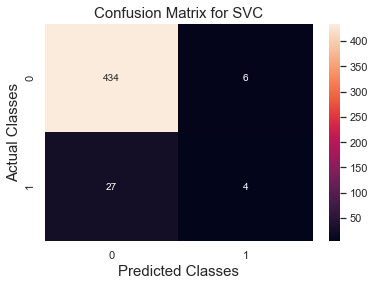

In [76]:
cm= confusion_matrix(Y_test, y_predsvm)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

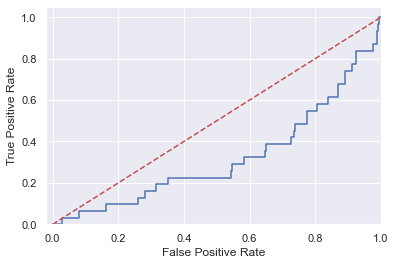

In [77]:
probs = svc_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_svm = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [78]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
23  0.647727  0.354839  0.352273  0.002566   0.336582


In [79]:
y_pred_prob = svc_cv.predict_proba(X_test)[:, 1]
# predict failed if the predicted probability is greater than 0.336582
y_pred_class = binarize([y_pred_prob], 0.336582)[0]
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.34265 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and 

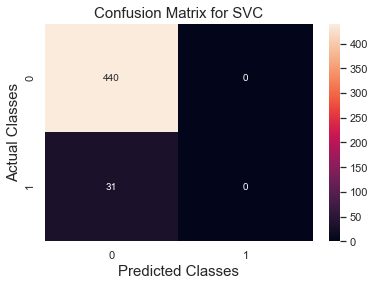

In [80]:
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True,  fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

In [110]:
precision_svm, recall_svm, f1_score_svm, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_svm)
print('Recall Score :', '%0.2f' % recall_svm)
print('F1-Score:', '%0.2f' % f1_score_svm)
svm_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % svm_acc)
print('AUC :','%0.2f' % roc_auc_svm)
print('Threshold :','%0.2f' % 0.336582)
Thresholdsvm=0.336582

Precision Score : 0.51
Recall Score : 0.53
F1-Score: 0.42
Accuracy Score : 0.56
AUC : 0.32
Threshold : 0.34


#### SVM with normal dataset

In [82]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# Train the classifier
svm_grid.fit(X_train, Y_train)
svm_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [83]:
svc_cv1 = SVC(kernel = 'sigmoid', gamma = 0.001, C = 1,probability=True)
svc_cv1.fit(X_train,Y_train)

SVC(C=1, gamma=0.001, kernel='sigmoid', probability=True)

In [84]:
sv_score = svc_cv1.score(X_train, Y_train)
print('Accuracy Score of Training Data: ', sv_score)
y_predsv= svc_cv1.predict(X_test)
sv1_score = accuracy_score(Y_test, y_predsv)
print('Accuracy Score of Test Data:', sv1_score)

Accuracy Score of Training Data:  0.9315693430656934
Accuracy Score of Test Data: 0.9320594479830149


In [85]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_predsv, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.96       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



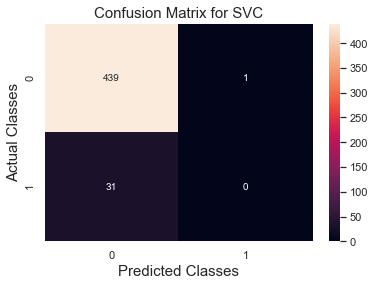

In [86]:
cm= confusion_matrix(Y_test, y_predsv)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

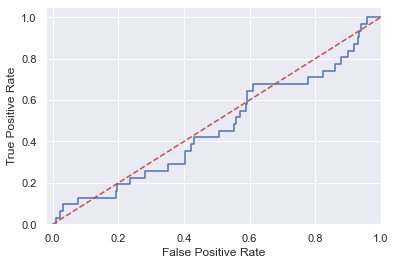

In [87]:
probs = svc_cv1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_sv1 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC = %0.2f)' % roc_auc_sv1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [88]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
28  0.552273  0.451613  0.447727  0.003886   0.063433


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.063249 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


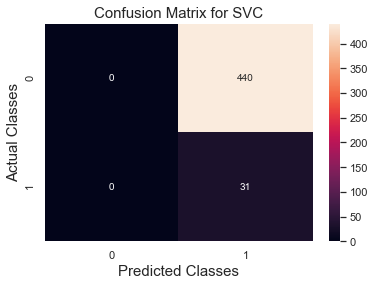

In [89]:
y_pred_prob = svc_cv.predict_proba(X_test)[:, 1]
# predict failed if the predicted probability is greater than 0.063433
y_pred_class = binarize([y_pred_prob], 0.063433)[0]
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVC', fontsize = 15);

In [111]:
precision_sv, recall_sv, f1_score_sv, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_sv)
print('Recall Score :', '%0.2f' % recall_sv)
print('F1-Score:', '%0.2f' % f1_score_sv)
sv_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % sv_acc)
print('AUC :','%0.2f' % roc_auc_sv1)
print('Threshold :','%0.2f' % 0.063433)
Thresholdsv=0.063433

Precision Score : 0.51
Recall Score : 0.53
F1-Score: 0.42
Accuracy Score : 0.56
AUC : 0.47
Threshold : 0.06


#### RandomForest with over sampled data

In [91]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = range(2,100,5)
min_samples_leaf = range(1,100,10)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion':['gini','entropy']}

In [92]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=90, n_jobs = -1)
rf_random.fit(X_over, Y_over)
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 463,
 'min_samples_split': 82,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': False}

In [93]:
rf_grid1 = RandomForestClassifier(n_estimators=463,
 min_samples_split= 82,
 min_samples_leaf=1,
 max_features= 'sqrt',
 max_depth= 110,
 criterion= 'gini',
 bootstrap= False)
rf_grid1.fit(X_over, Y_over)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_split=82, n_estimators=463)

In [94]:
rfg1_score=rf_grid1.score(X_over,Y_over)
print('Accuracy Score of Training Data: ', rfg1_score)
y_predrfg1= rf_grid1.predict(X_test)
rfg2_score = accuracy_score(Y_test, y_predrfg1)
print('Accuracy Score of Test Data:', rfg2_score)

Accuracy Score of Training Data:  1.0
Accuracy Score of Test Data: 0.9341825902335457


In [95]:
print("Classification Report")
print(metrics.classification_report(Y_test, y_predrfg1, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        31
           0       0.93      1.00      0.97       440

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


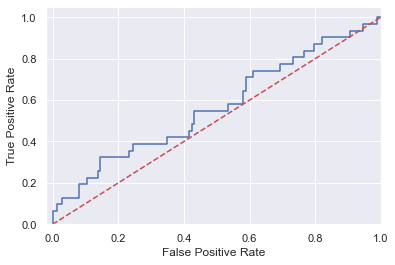

In [96]:
probs = rf_grid1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_rf1 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RF over sampled (AUC = %0.2f)' % roc_auc_rf1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [97]:
i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])

         fpr       tpr     1-fpr        tf  threshold
28  0.429545  0.548387  0.570455 -0.022067   0.151115


In [98]:
y_pred_prob = rf_grid1.predict_proba(X_test)[:, 1]
# predict fail if the predicted probability is greater than 0.151115
y_pred_class = binarize([y_pred_prob], 0.151115)[0]
print("Classification Report")
print(metrics.classification_report(Y_test, y_pred_class, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.07      0.48      0.13        31
           0       0.94      0.57      0.71       440

    accuracy                           0.56       471
   macro avg       0.51      0.53      0.42       471
weighted avg       0.88      0.56      0.67       471



C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass threshold=0.152114 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


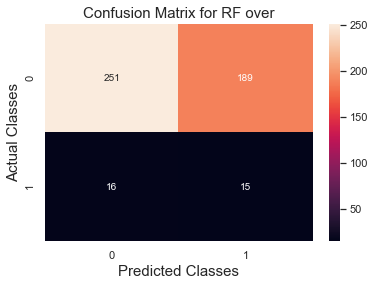

In [99]:
cm= confusion_matrix(Y_test, y_pred_class)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.ylabel('Actual Classes', fontsize = 15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for RF over', fontsize = 15);

In [112]:
precision_rf1, recall_rf1, f1_score_rf1, support = precision_recall_fscore_support(Y_test, y_pred_class, average = 'macro')
print('Precision Score :', '%0.2f' % precision_rf1)
print('Recall Score :', '%0.2f' % recall_rf1)
print('F1-Score:', '%0.2f' % f1_score_rf1)
rf1_acc= accuracy_score(Y_test, y_pred_class)
print('Accuracy Score :','%0.2f' % rf1_acc)
print('AUC :','%0.2f' % roc_auc_rf1)
print('Threshold :','%0.2f' % 0.151115)
Thresholdrf1=0.151115

Precision Score : 0.51
Recall Score : 0.53
F1-Score: 0.42
Accuracy Score : 0.56
AUC : 0.57
Threshold : 0.15


In [113]:
modellists = []
modellists.append(['SVM Normal Data', sv_acc * 100, recall_sv * 100, precision_sv * 100,roc_auc_sv1*100,f1_score_sv*100,Thresholdsv])
modellists.append(['SVM under samples data', svm_acc* 100, recall_svm * 100, precision_svm* 100,roc_auc_svm*100,f1_score_svm*100,Thresholdsvm])
modellists.append(['Random Forest Over sampled Data', rf1_acc * 100, recall_rf1 * 100, precision_rf1 * 100,roc_auc_rf1*100,f1_score_rf1*100,Thresholdrf1])
model_df1 = pd.DataFrame(modellists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','AUC','F1 Score','Threshold'])
model_df1

,Model,Accuracy Scores on Test,Recall Score,Precision Score,AUC,F1 Score,Threshold
0,SVM Normal Data,56.475584,52.716276,50.680216,46.620235,41.8851,0.063433
1,SVM under samples data,56.475584,52.716276,50.680216,32.045455,41.8851,0.336582
2,Random Forest Over sampled Data,56.475584,52.716276,50.680216,56.774194,41.8851,0.151115


In [102]:
val_pca=pd.DataFrame(val_pca)
val1=val_pca.copy()
val1=pd.DataFrame(val1)
val1=val1.reset_index(drop=True)
val2=val_pca.copy()
val2=pd.DataFrame(val2)
val2=val2.reset_index(drop=True)

In [103]:
svc_cv.fit(X_under,Y_under)
pred=svc_cv.predict(val1)
val1['Pass/Fail'] = pred
val1 = val1[(val1['Pass/Fail'] == 0)]
val1.head(18)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Pass/Fail
0,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
1,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
2,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
3,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
4,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
5,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
6,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
7,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
8,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0
9,-7.29162,3.280519,-3.449665,-3.482773,-3.569594,5.437026,2.783621,-3.509661,-10.566938,8.657819,...,-0.349332,8.768845,-9.084372,-4.148342,1.106447,-5.005101,2.768811,3.441293,0.868556,0


In [104]:
#I couldnt come to a point as to why i am getting all the validation cases to be 0 i:e Fail category.

In [114]:
model = pd.concat([model_df, model_df1],keys = ['Without PCA','With PCA'], axis = 0)
model

Model  \
Without PCA 0                 Gaussian NB Normal Data   
            1  Logistic Regression under samples data   
            2         Random Forest Over sampled Data   
With PCA    0                         SVM Normal Data   
            1                  SVM under samples data   
            2         Random Forest Over sampled Data   

               Accuracy Scores on Test  Recall Score  Precision Score  \
Without PCA 0                85.138004     63.508065        53.482328   
            1                70.700637     52.716276        50.680216   
            2                56.475584     52.716276        50.680216   
With PCA    0                56.475584     52.716276        50.680216   
            1                56.475584     52.716276        50.680216   
            2                56.475584     52.716276        50.680216   

                     AUC   F1 Score  Threshold  
Without PCA 0  69.743402  47.138047   0.005800  
            1  65.989736  41.885100   0.134702  
            2  71.502933  41.885100   0.161671  
With PCA    0  46.620235  41.885100   0.063433  
            1  32.045455  41.885100   0.336582  
            2  56.774194  41.885100   0.151115

### Conclusion

GaussianNB on Normal Data gives an Accuracy score of 85%.(Without PCA)
Random Forest on Random oversampling data gives the overall best results both with and without PCA.
The models do better without the help of PCA.